#Fine-tuning RoBERTa for news category classification

##Import and install dependencies

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import tensorflow.keras as keras
!pip install transformers
import transformers
#Download dataset from GCS. Path must be retrieved from Kaggle, it changes periodically
!gsutil cp "gs://kds-02bf1add8736410c02d6cec08a1d15ed43db53055cd59550965f75e1/News_Category_Dataset_v2.json" .
import json
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import matplotlib.pyplot as plt
import random

     |████████████████████████████████| 2.6 MB 5.3 MB/s 
     |████████████████████████████████| 3.3 MB 35.6 MB/s 
     |████████████████████████████████| 895 kB 55.9 MB/s 
     |████████████████████████████████| 636 kB 38.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Copying gs://kds-02bf1add8736410c02d6cec08a1d15ed43db53055cd59550965f75e1/News_Category_Dataset_v2.json...
| [1 files][ 80.0 MiB/ 80.0 MiB]                                                
Operation completed over 1 objects/80.0 MiB.                                     


##Initialize TPU Strategy

In [2]:
# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

batch_size=32 * tpu_strategy.num_replicas_in_sync
print('Batch size:', batch_size)
AUTOTUNE = tf.data.experimental.AUTOTUNE


INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.77.63.106:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.77.63.106:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Batch size: 256


##Visualize and preprocess data

Let's load the data. We will combine the title and the description into a single string we will use as input for the model. 

In [3]:
data = [json.loads(line) for line in open('/content/News_Category_Dataset_v2.json', 'r')] #Load data from json file
random.shuffle(data) #shuffle data 
labels=[]
headlines=[]
texts=[]
for line in data:
    labels.append(line['category'])
    headlines.append(line['headline'])
    text=line['headline']+' '+line['short_description'] #Combine headline and description into a single text input
    texts.append(text)


Let's explore the data

In [4]:
n_elements=len(headlines)
print('Elements in dataset:', n_elements)
categories=sorted(list(set(labels))) #set will return the unique different entries
n_categories=len(categories)
print("{} categories found:".format(n_categories))
for category in categories:
    print(category)

Elements in dataset: 200853
41 categories found:
ARTS
ARTS & CULTURE
BLACK VOICES
BUSINESS
COLLEGE
COMEDY
CRIME
CULTURE & ARTS
DIVORCE
EDUCATION
ENTERTAINMENT
ENVIRONMENT
FIFTY
FOOD & DRINK
GOOD NEWS
GREEN
HEALTHY LIVING
HOME & LIVING
IMPACT
LATINO VOICES
MEDIA
MONEY
PARENTING
PARENTS
POLITICS
QUEER VOICES
RELIGION
SCIENCE
SPORTS
STYLE
STYLE & BEAUTY
TASTE
TECH
THE WORLDPOST
TRAVEL
WEDDINGS
WEIRD NEWS
WELLNESS
WOMEN
WORLD NEWS
WORLDPOST


Let's visualize a histogram for the categories. 

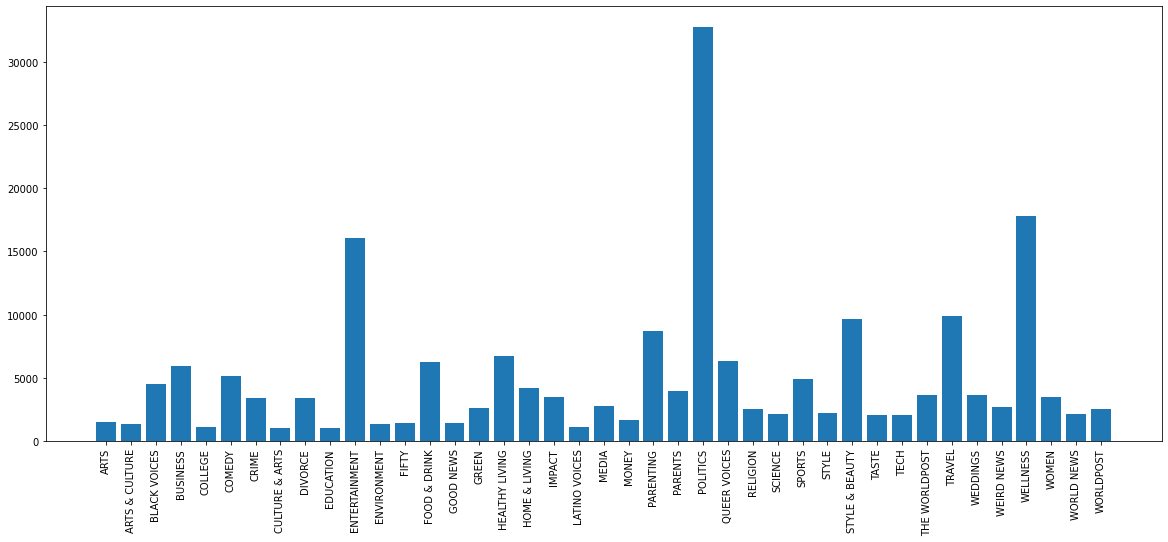

In [5]:
fig=plt.figure(figsize=(20,8))
lbl, counts = np.unique(labels,return_counts=True)
ticks = range(len(counts))
plt.bar(ticks,counts, align='center')
plt.xticks(ticks,lbl)
plt.xticks(rotation=90)
plt.show()

We see we have a lot of categories with few entries. Furthermore some categories may have a significant overlapping in meaning. Since there is a significant number of categories to predict, I will aggregate the categories that refer to related concepts. This will make them easier to be distinguished by the classifier later.

In [6]:
def aggregate_categories(labels):
    aggregated=[]
    for line in labels:
        if line=='WORLDPOST' or line=='THE WORLDPOST':
            aggregated.append('WORLD NEWS')
        elif line=='PARENTING':
            aggregated.append('PARENTS')
        elif line=='ARTS' or line=='CULTURE & ARTS':
            aggregated.append('ARTS & CULTURE')
        elif line=='STYLE':
            aggregated.append('STYLE & BEAUTY')
        elif line=='GREEN' or line=='ENVIRONMENT':
            aggregated.append('ENVIRONMENT & GREEN')
        elif line=='HEALTHY LIVING' or line=='WELLNESS':
            aggregated.append('WELLNESS & HEALTHY LIVING')
        elif line=='COMEDY' or line=='ENTERTAINMENT':
            aggregated.append('ENTERTAINMENT & COMEDY')
        elif line=='TASTE' or line=='FOOD & DRINK':
            aggregated.append('FOOD, DRINK & TASTE')
        elif line=='COLLEGE' or line=='EDUCATION':
             aggregated.append('COLLEGE & EDUCATION')
        elif line=='SCIENCE' or line=='TECH':
             aggregated.append('SCIENCE & TECH')
        elif line=='BUSINESS' or line=='MONEY':
            aggregated.append('BUSINESS & MONEY')

        else:
            aggregated.append(line)
    return aggregated

#count number of unique categories
aggregated=aggregate_categories(labels)
categories=sorted(list(set(aggregated)))
n_categories=len(categories)
print('There are {} aggregated categories:'.format(n_categories))
for category in categories:
    print(category)


There are 28 aggregated categories:
ARTS & CULTURE
BLACK VOICES
BUSINESS & MONEY
COLLEGE & EDUCATION
CRIME
DIVORCE
ENTERTAINMENT & COMEDY
ENVIRONMENT & GREEN
FIFTY
FOOD, DRINK & TASTE
GOOD NEWS
HOME & LIVING
IMPACT
LATINO VOICES
MEDIA
PARENTS
POLITICS
QUEER VOICES
RELIGION
SCIENCE & TECH
SPORTS
STYLE & BEAUTY
TRAVEL
WEDDINGS
WEIRD NEWS
WELLNESS & HEALTHY LIVING
WOMEN
WORLD NEWS


Let's visualize the histogram with the aggregated categories.


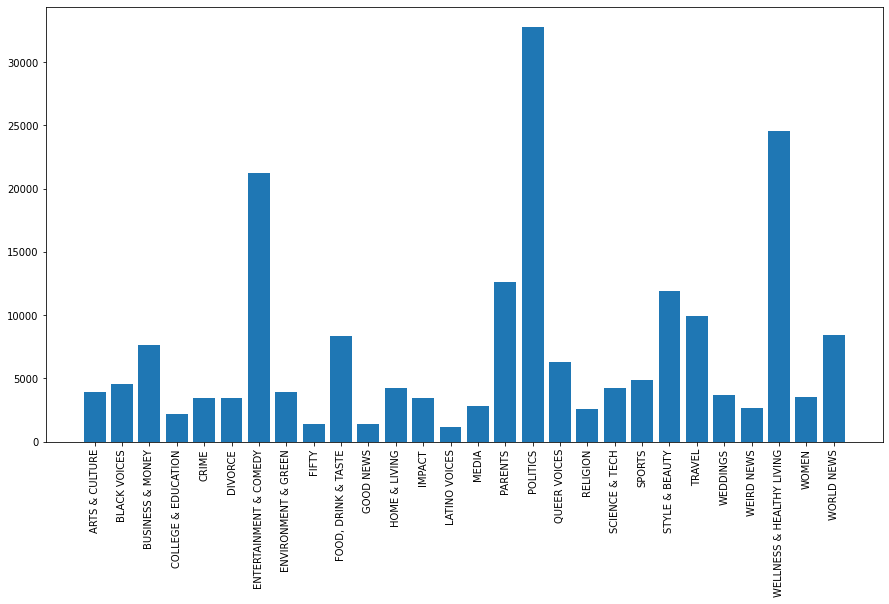

In [7]:
fig=plt.figure(figsize=(15,8))
agg, counts = np.unique(aggregated,return_counts=True)
ticks = range(len(counts))
plt.bar(ticks,counts, align='center')
plt.xticks(ticks,agg)
plt.xticks(rotation=90)
plt.show()


Let's now prepare the dataset to feed it to the model. We need to transform the category labels into indices and to tokenize the input text. The AutoTokenizer class of Huggingface allows to tokenize the dataset using the tokenizer used in the pretraining of the model. We will use the "roberta-base" model. 

In [8]:
def indicize_labels(labels):
    """Transforms string labels into indices"""
    indices=[]
    for j in range(len(labels)):
        for i in range(n_categories):
            if labels[j]==list(categories)[i]:
                indices.append(i)
    return indices
 
indices=indicize_labels(aggregated) #Integer label indices
tokenizer = AutoTokenizer.from_pretrained("roberta-base") #Tokenizer
inputs = tokenizer(texts, padding=True, truncation=True, return_tensors='tf') #Tokenized text
dataset=tf.data.Dataset.from_tensor_slices((dict(inputs), indices)) #Create a tensorflow dataset
#train test split, we use 10% of the data for validation
val_data_size=int(0.1*n_elements)
val_ds=dataset.take(val_data_size).batch(batch_size, drop_remainder=True) #use the first 10% of cases for validation 
train_ds=dataset.skip(val_data_size).batch(batch_size, drop_remainder=True)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/657M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


706/706 [==============================] - ETA: 0s - loss: 1.3489 - sparse_categorical_accuracy: 0.6614WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


706/706 [==============================] - 568s 571ms/step - loss: 1.3489 - sparse_categorical_accuracy: 0.6614 - val_loss: 0.9281 - val_sparse_categorical_accuracy: 0.7442
Epoch 2/5
706/706 [==============================] - 396s 560ms/step - loss: 0.8912 - sparse_categorical_accuracy: 0.7517 - val_loss: 0.8335 - val_sparse_categorical_accuracy: 0.7586
Epoch 3/5
706/706 [==============================] - 395s 560ms/step - loss: 0.7798 - sparse_categorical_accuracy: 0.7755 - val_loss: 0.7976 - val_sparse_categorical_accuracy: 0.7674
Epoch 4/5
706/706 [==============================] - 395s 559ms/step - loss: 0.7068 - sparse_categorical_accuracy: 0.7935 - val_loss: 0.7792 - val_sparse_categorical_accuracy: 0.7707
Epoch 5/5
706/706 [==============================] - 395s 560ms/step - loss: 0.6458 - sparse_categorical_accuracy: 0.8094 - val_loss: 0.7780 - val_sparse_categorical_accuracy: 0.7725


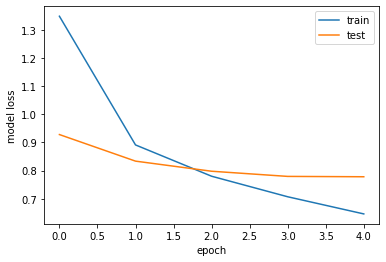

In [9]:
with tpu_strategy.scope():
    model = TFAutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=n_categories)
    model.compile(
        optimizer=tf.keras.optimizers.Nadam(learning_rate=1e-5, clipnorm=1.),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=tf.metrics.SparseCategoricalAccuracy(),
        )
 
history=model.fit(train_ds, validation_data=val_ds, epochs=5, verbose=1)

model.save_weights('/content/saved_weights.h5')

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.savefig('train_history.png')
 
plt.show()

In [10]:
trained_model = TFAutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=n_categories)
trained_model.load_weights('/content/saved_weights.h5')

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
labels=[]
texts=[]
for i in range(val_data_size):
    labels.append(data[i]['category'])
    headline=data[i]['headline']
    description=data[i]['short_description']
    texts.append(headline+' '+description)
labels=indicize_labels(aggregate_categories(labels))
tokens=tokenizer(texts, padding=True,truncation=True, return_tensors='tf')
logits=trained_model.predict(dict(tokens)).logits
prob=tf.nn.softmax(logits, axis=1).numpy()
predictions=np.argmax(prob, axis=1)
print(predictions[0])
confusion_matrix=tf.math.confusion_matrix(labels, predictions, num_classes=n_categories)


8


Let's visualize the confusion matrix over the validation set. 

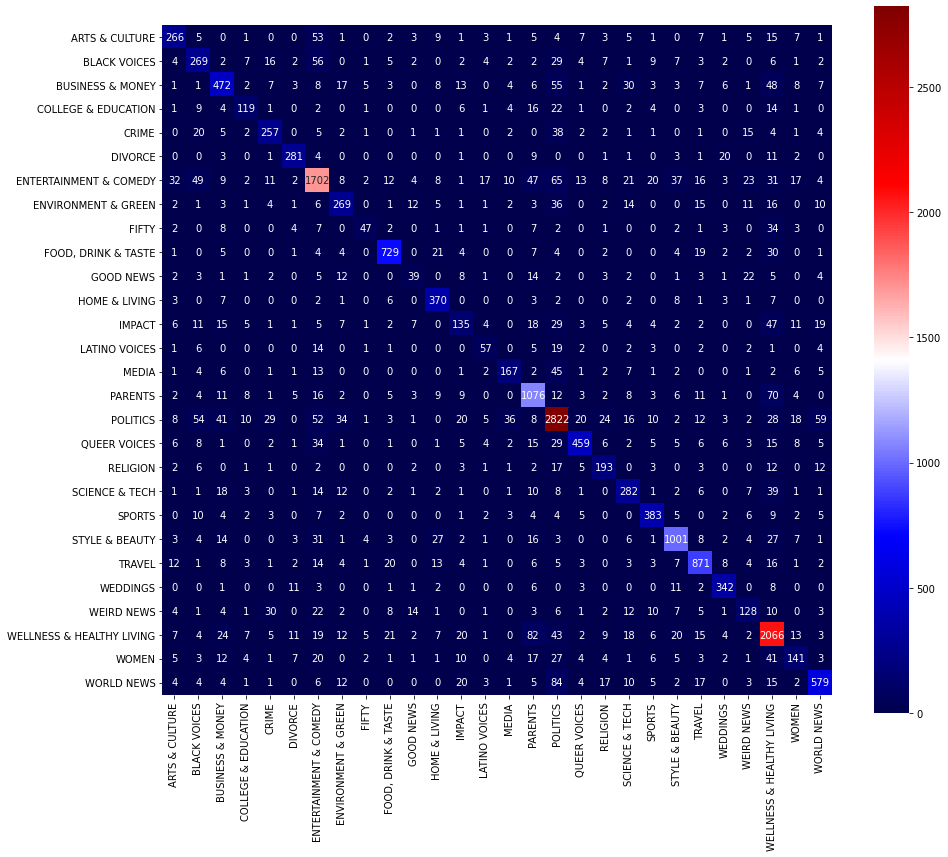

In [12]:
import seaborn as sn
plt.figure(figsize=(15,13))
sn.heatmap(confusion_matrix, annot=True, fmt='d', cmap='seismic', square=True, xticklabels=categories, yticklabels=categories) 


Let's plot an histogram of the misclassified examples per class. 

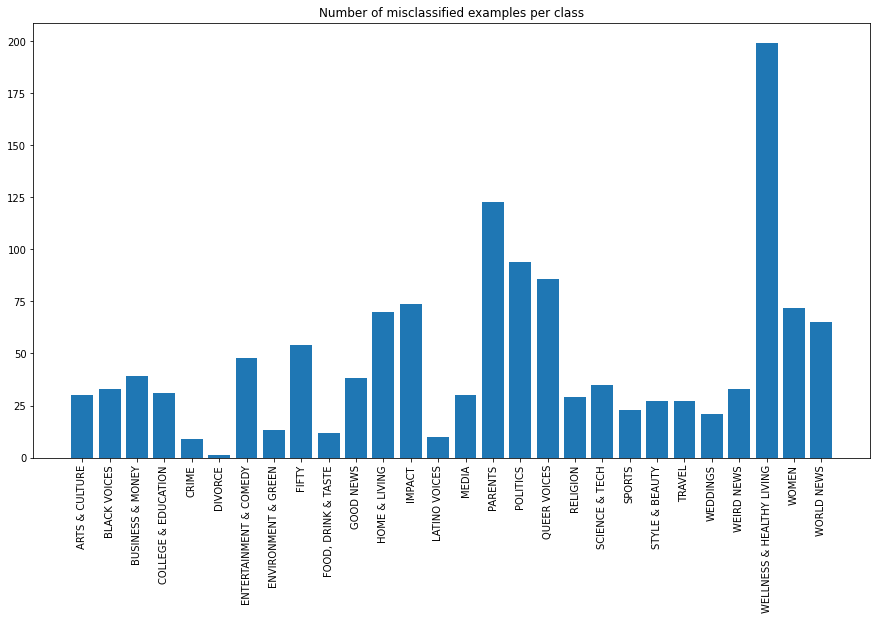

In [13]:
fig=plt.figure(figsize=(15,8))
indices, counts = np.unique(labels,return_counts=True)
pred_indices, pred_counts = np.unique(predictions,return_counts=True)
difference=abs(pred_counts-counts)
ticks = range(len(counts))
plt.bar(ticks,difference, align='center')
plt.xticks(ticks,categories)
plt.xticks(rotation=90)
plt.title('Number of misclassified examples per class')
plt.show()

Since the dataset is higly unbalanced, it is more meaningful to consider the percentage of misclassified examples per class. 

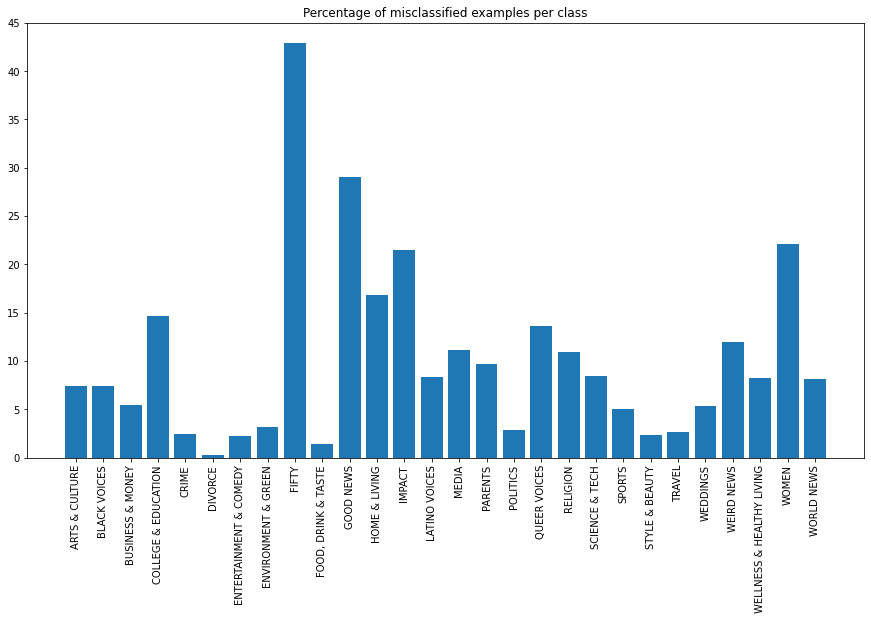

In [14]:
fig=plt.figure(figsize=(15,8))
indices, counts = np.unique(labels,return_counts=True)
pred_indices, pred_counts = np.unique(predictions,return_counts=True)
percentage=(abs(pred_counts-counts)/counts)*100
ticks = range(len(counts))
plt.bar(ticks,percentage, align='center')
plt.xticks(ticks,categories)
plt.xticks(rotation=90)
plt.title('Percentage of misclassified examples per class')
plt.show()

As expected, the classes with the highest percentage of misclassified samples are the ones that are less represented in the training set. 

Let's compare the performance of the model when we feed only the headlines without the short description.

In [15]:
labels=[]
texts=[]
for i in range(val_data_size):
    labels.append(data[i]['category'])
    headline=data[i]['headline']
    texts.append(headline)
labels=indicize_labels(aggregate_categories(labels))
labels=np.asarray(labels)
tokens=tokenizer(texts, padding=True,truncation=True, return_tensors='tf')
logits=trained_model.predict(dict(tokens)).logits
prob=tf.nn.softmax(logits, axis=1).numpy()
predictions=np.argmax(prob, axis=1)
confusion_matrix=tf.math.confusion_matrix(labels, predictions, num_classes=n_categories)
accuracy=(1-np.count_nonzero(predictions-labels)/labels.shape[0])*100
print('Accuracy on healines only:', accuracy)

Accuracy on healines only: 70.16679113766493
